## Selecting optimum locations for mobile towers/ WiFi hotspots using k-means

#### By-Vineet Puri


### Introduction

#### 1.1 Background
##### Network planning is an important task in any telecommunication company. We need to provide good coverage at all the required locations at minimum cost. As the number of towers increase, the cost of installation and maintenance also rises. So, we need to install towers in such a way that our target of coverage is achieved with minimum number of towers. In this project, I have tried to achieve this by using data science tools.

#### 1.2 Business Problem
##### A huge sports event is going to be organised in the city of Toronto. As a telecommunication company we wish demonstrate our 5G technology during this event. It has been decided by the management that priority will be to cover all the public places or venues in the area and this needs to be done by installing minimum possible number of towers/antennae. So, our main target is to provide coverage at the selected venues even if there is no coverage at places outside the venues. 

##### Also, the range of our 5G towers is 400 to 500 meters. So, any venue which is more than 400 meters away from the tower will be considered out of range. As a data scientist we need to calculate the best locations to install these towers so that all important places are covered with minimum number of towers.

#### 1.3 Interest
##### This kind of implementation of data science can be of interest to telecommunication companies who wish to plan their future networks. Although, I have taken the example of mobile towers in this project but the strategy can be used to plan WiFi hotspots and other radio networks too.

####  2. Data description

##### I have used Foursquare API to get the list of venues in the target area. We need to provide coverage at all these venues in this list. We need latitude, longitude, venue name from Foursquare around our target location. We selected a target area on map and got its latitude and longitude from google maps. We fetched all the venues in an area of approximately  7X7 Kms centred at our target location.

##### I am using free service of Foursquare which gives me a limited number of venues around a location at a time. So, to overcome that I created a square grid (5X5) of 25 locations ( I called them city points ) centred at the target location and then fetched the list of venues for all these locations  within 1 Km radius from Foursquare.

#### 3. Methodology
##### Let us first import the Numpy and Pandas libraries

In [159]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

#### Intall folium to draw maps

In [160]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


### Import other required libraries

In [161]:
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Libraries imported.')

Libraries imported.


### Define the lat , long of a location in Toronto where we need to plan our towers. 

In [162]:
latitude1 = 43.74864909867068 
longitude1 = -79.38463791281924
print('The geograpical coordinates of a location to plan towers in Toronto are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinates of a location to plan towers in Toronto are 43.74864909867068, -79.38463791281924.


### Set up the Foursquare credentials

In [228]:
# @hidden_cell
CLIENT_ID = '****' # your Foursquare ID
CLIENT_SECRET = '****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Foursquare credentails ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Foursquare credentails 
CLIENT_ID: ****
CLIENT_SECRET:****


### We will write a function to get venues data from Foursquare

In [166]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City Points', 
                  'City Points Latitude', 
                  'City Points Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Create  a square grid(5X5) of 25 locations centered at the required location and then fetch the list of venues for all these locations from Foursquare. We will obviously get duplicate venues which we will correct later.

In [167]:
names=[]
latitudes=[]
longitudes=[]
for i in range(1,6):
    for j in range(1,6):        
        names.append('Toronto ' + str(i) + str(j))
        latitudes.append(str(latitude1-.03+i*0.01))
        longitudes.append(str(longitude1-.03+j*0.01))

#### We have got an array latitudes and longitudes which contains a 5X5 grid or 25 locations centered at the target location

In [168]:
print(latitudes)
print(longitudes)

['43.72864909867068', '43.72864909867068', '43.72864909867068', '43.72864909867068', '43.72864909867068', '43.738649098670685', '43.738649098670685', '43.738649098670685', '43.738649098670685', '43.738649098670685', '43.74864909867068', '43.74864909867068', '43.74864909867068', '43.74864909867068', '43.74864909867068', '43.75864909867068', '43.75864909867068', '43.75864909867068', '43.75864909867068', '43.75864909867068', '43.76864909867068', '43.76864909867068', '43.76864909867068', '43.76864909867068', '43.76864909867068']
['-79.40463791281924', '-79.39463791281925', '-79.38463791281924', '-79.37463791281924', '-79.36463791281925', '-79.40463791281924', '-79.39463791281925', '-79.38463791281924', '-79.37463791281924', '-79.36463791281925', '-79.40463791281924', '-79.39463791281925', '-79.38463791281924', '-79.37463791281924', '-79.36463791281925', '-79.40463791281924', '-79.39463791281925', '-79.38463791281924', '-79.37463791281924', '-79.36463791281925', '-79.40463791281924', '-79.3

### Now by using our function we will extract venues in the area from Foursquare

In [219]:
toronto_venues = getNearbyVenues(names=names,
                                   latitudes=latitudes,
                                   longitudes=longitudes
                                  )

Toronto 11
Toronto 12
Toronto 13
Toronto 14
Toronto 15
Toronto 21
Toronto 22
Toronto 23
Toronto 24
Toronto 25
Toronto 31
Toronto 32
Toronto 33
Toronto 34
Toronto 35
Toronto 41
Toronto 42
Toronto 43
Toronto 44
Toronto 45
Toronto 51
Toronto 52
Toronto 53
Toronto 54
Toronto 55


In [220]:
toronto_venues.shape

(771, 7)

#### We have got list of venues for the 25 locations or city points in Toronto as you can see

In [221]:
toronto_venues.head(10)

,City Points,City Points Latitude,City Points Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toronto 11,43.72864909867068,-79.40463791281924,Bobbette & Belle,43.731339,-79.403769,Bakery
1,Toronto 11,43.72864909867068,-79.40463791281924,For The Win Cafe,43.728636,-79.403255,Bubble Tea Shop
2,Toronto 11,43.72864909867068,-79.40463791281924,T-buds,43.731247,-79.403640,Tea Room
3,Toronto 11,43.72864909867068,-79.40463791281924,Mastermind Toys,43.732046,-79.404141,Toy / Game Store
4,Toronto 11,43.72864909867068,-79.40463791281924,Menchies Frozen Yogurt,43.728336,-79.403173,Ice Cream Shop
5,Toronto 11,43.72864909867068,-79.40463791281924,The Belly Buster Submarines,43.733743,-79.404390,Sandwich Place
6,Toronto 11,43.72864909867068,-79.40463791281924,Shinobu by Maki Sushi,43.732562,-79.404147,Japanese Restaurant
7,Toronto 11,43.72864909867068,-79.40463791281924,The Burger Cellar,43.732362,-79.403894,Burger Joint
8,Toronto 11,43.72864909867068,-79.40463791281924,STACK,43.729311,-79.403241,BBQ Joint
9,Toronto 11,43.72864909867068,-79.40463791281924,The Rolling Pin,43.733315,-79.404318,Bakery


#### Since there is a repetition of venues and we are only interested in unique values, we will first check how many unique values are there.

In [222]:
toronto_venues['Venue'].nunique()

281

#### So, we got 281 unique venues which we need to cover

In [206]:
toronto_venues.groupby('City Points').count()

,City Points Latitude,City Points Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Tower,Tower category
City Points,,,,,,,,
Toronto 11,56,56,56,56,56,56,56,56
Toronto 12,5,5,5,5,5,5,5,5
Toronto 13,8,8,8,8,8,8,8,8
Toronto 14,7,7,7,7,7,7,7,7
Toronto 15,5,5,5,5,5,5,5,5
Toronto 21,11,11,11,11,11,11,11,11
Toronto 22,2,2,2,2,2,2,2,2
Toronto 23,6,6,6,6,6,6,6,6
Toronto 25,2,2,2,2,2,2,2,2


#### Let us delete the duplicate venues

In [173]:
toronto_venues.drop_duplicates(subset='Venue',inplace=True)

In [174]:
toronto_venues.groupby('City Points').count()

,City Points Latitude,City Points Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City Points,,,,,,
Toronto 11,56,56,56,56,56,56
Toronto 12,5,5,5,5,5,5
Toronto 13,8,8,8,8,8,8
Toronto 14,7,7,7,7,7,7
Toronto 15,5,5,5,5,5,5
Toronto 21,11,11,11,11,11,11
Toronto 22,2,2,2,2,2,2
Toronto 23,6,6,6,6,6,6
Toronto 25,2,2,2,2,2,2


In [223]:
toronto_venues.head(10)

,City Points,City Points Latitude,City Points Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toronto 11,43.72864909867068,-79.40463791281924,Bobbette & Belle,43.731339,-79.403769,Bakery
1,Toronto 11,43.72864909867068,-79.40463791281924,For The Win Cafe,43.728636,-79.403255,Bubble Tea Shop
2,Toronto 11,43.72864909867068,-79.40463791281924,T-buds,43.731247,-79.403640,Tea Room
3,Toronto 11,43.72864909867068,-79.40463791281924,Mastermind Toys,43.732046,-79.404141,Toy / Game Store
4,Toronto 11,43.72864909867068,-79.40463791281924,Menchies Frozen Yogurt,43.728336,-79.403173,Ice Cream Shop
5,Toronto 11,43.72864909867068,-79.40463791281924,The Belly Buster Submarines,43.733743,-79.404390,Sandwich Place
6,Toronto 11,43.72864909867068,-79.40463791281924,Shinobu by Maki Sushi,43.732562,-79.404147,Japanese Restaurant
7,Toronto 11,43.72864909867068,-79.40463791281924,The Burger Cellar,43.732362,-79.403894,Burger Joint
8,Toronto 11,43.72864909867068,-79.40463791281924,STACK,43.729311,-79.403241,BBQ Joint
9,Toronto 11,43.72864909867068,-79.40463791281924,The Rolling Pin,43.733315,-79.404318,Bakery


#### Let us map these venues

In [176]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, venue in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Now we will create an array containing lat, long of all the venues

In [178]:
a=toronto_venues['Venue Latitude'].tolist()
b=toronto_venues['Venue Longitude'].tolist()
X=np.column_stack((a,b))

### We will plot the venues without map as a scatter plot to see the spread of venues

In [179]:
import matplotlib.pyplot as plt 

Text(0, 0.5, 'Longitude')

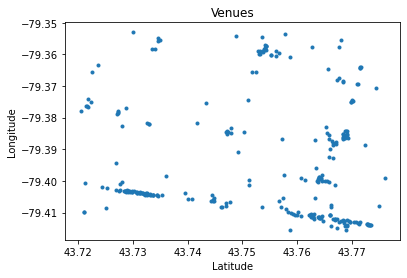

In [226]:
plt.scatter(X[:, 0], X[:, 1], marker='.')
plt.title("Venues")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

#### Let us import the Kmeans library

In [181]:
from sklearn.cluster import KMeans  
%matplotlib inline

#### Let us first start with 20 clusters and see the distribution

In [208]:
k_means = KMeans(init = "k-means++", n_clusters = 20, n_init = 12)

In [209]:
k_means.fit(X)

KMeans(n_clusters=20, n_init=12)

#### Check the array of labels or tower id  assigned to all the venues

In [210]:
k_means_labels = k_means.labels_
k_means_labels

array([ 2, 11,  2,  2, 11,  2,  2,  2, 11,  2,  2,  2,  2,  2, 11,  2,  2,
        2, 11,  2, 11, 11, 11, 11,  2,  2,  2,  2, 11,  2, 11, 11,  2,  2,
        2, 11, 11,  2, 11, 11,  2, 11,  2,  2, 11, 11,  2,  2, 11, 11, 11,
       19,  2, 11, 19, 19, 11,  2,  2, 15, 11, 15, 15, 15, 15, 15, 15, 15,
       15, 18,  5,  5,  5,  5,  5,  5, 10, 10, 18, 10, 10,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  1,  1,  1,  1,  1,  1, 10, 10,
        9, 16,  9,  9, 16, 16, 16,  1,  1,  1,  9,  1,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4, 16, 16,  8,  6, 16, 16,  6,  6,  6,  6, 16,  6,  6,  6,  6,
        6, 16,  6,  8,  6,  8,  6,  8,  6,  6,  6,  8,  6, 16, 16,  6,  6,
        6,  8,  6,  8,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,
       16,  6,  6,  7,  7,  8,  7,  7,  7,  7,  7,  7,  7,  1,  7,  7,  7,
        1,  4, 14, 12,  4, 13, 13, 13, 13, 13,  0,  0, 13, 13, 13,  0,  0,
       13, 13,  0, 13, 13

#### We will separately store the centers of clusters. 

In [211]:
k_means_cluster_centers = k_means.cluster_centers_
len(k_means_cluster_centers)

20

### But we have not taken into account the distance of venues from the cluster centers. We define a function to calculate distance between the venues and their cluster centers or tower location

In [186]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [187]:
import geopy.distance
from geopy.distance import geodesic 

In [188]:
def distance(list_a,list_b):
    return np.array([ geopy.distance.geodesic(i, list_b).m for i in list_a])

#### We will plot the venues again but this time with their cluster centers(towers). Also, the range of our 5G towers is 400 to 500 meters. So, any venue which is more than 400 m away from the center will be considered out of range and will be plotted as a (X). Venues within range of towers will be marked as a dot (.) and towers themselves will be marked as triangles.

In [212]:
towers=20

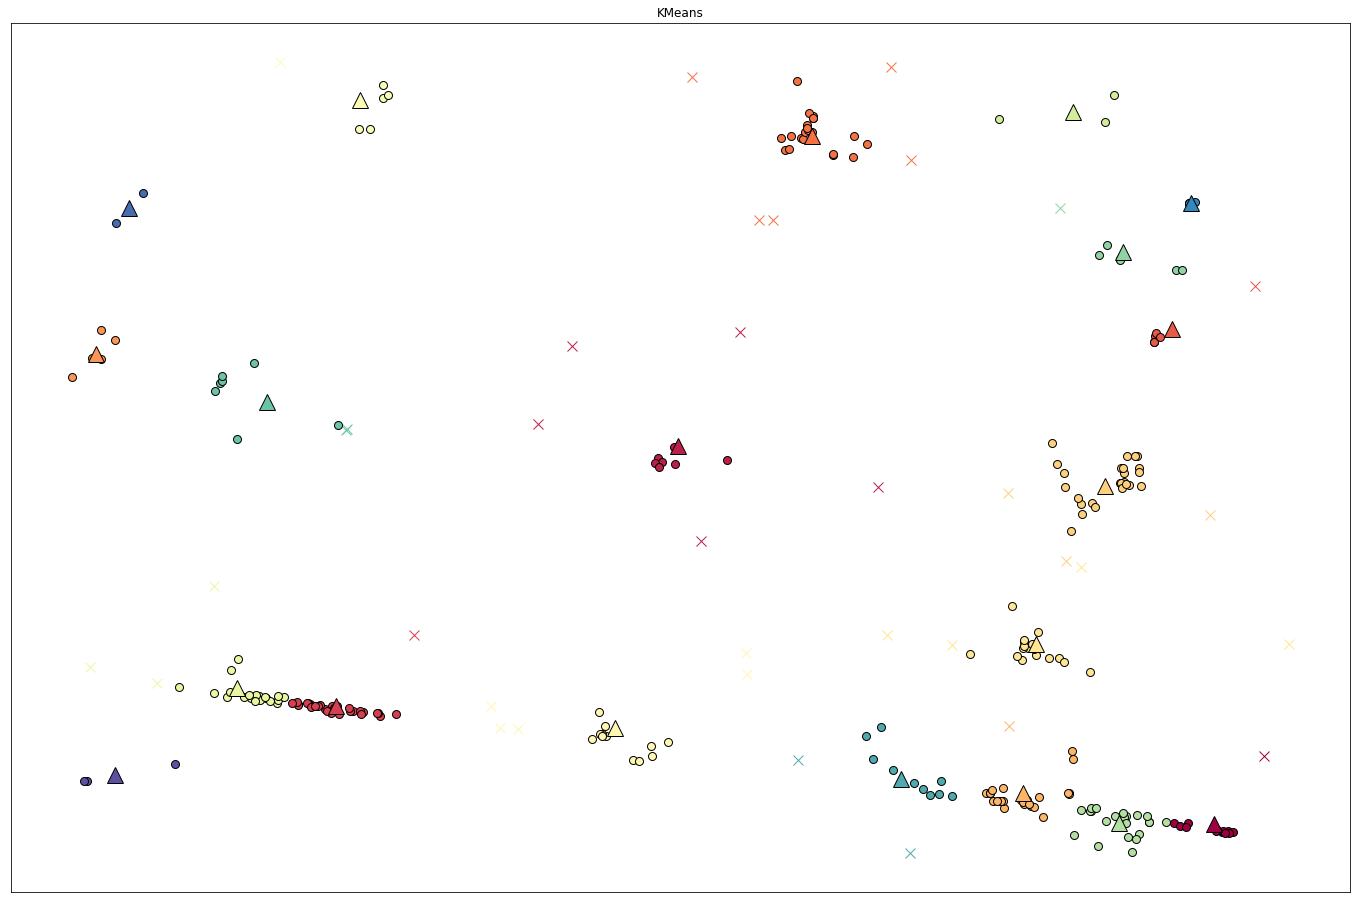

In [213]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(24, 16))
dis_all_list=[]
# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
color_list = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)




# For loop that plots the data points and centroids.
# k will range from 0-19, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(towers), color_list):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k )
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    #Calculate distance from their own centroids
    point1 = np.array(X[my_members]) 
    point2 = np.array((cluster_center[0],cluster_center[1]))
    dist=distance(point1,point2)
    dis_mask=dist>400
    dis_all_list.extend(dist)
   

    # Plots the datapoints with color col.
    ax.plot(point1[dis_mask , 0], point1[dis_mask, 1], 'x', markerfacecolor=col, marker='x', markersize=10,color=col) 
    ax.plot(point1[~dis_mask , 0], point1[~dis_mask, 1], 'x', markerfacecolor=col, marker='o', markeredgecolor='k',markersize=8,color=col)
    #ax.plot(X[my_members , 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')  
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], '^', markerfacecolor=col,  markeredgecolor='k', markersize=16)    

    
# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

#### As you can see there are many venues which are far more than 400 meters away from their allotted cluster centers and are marked as X in plot. You may need to zoom in to see properly. So, these will be out of range from tower which will be installed at the center. We need to adjust the number of clusters in such a way that all venues are within range. Let's check the maximum distance of a venue from its center out of all the venues.

In [214]:
max(dis_all_list)

1284.530050995566

#### We need to go through the different values of number of clusters and perform K means for each value. Then we need to select the minimum value of number of clusters that will cover all the venues. Since, each cluster will be served by one tower, we will be able to minimise the number of towers to be installed. We will check all the values for number of towers from 20 to 100 and perform k-means for all these values.

In [192]:
max_dist_list=[]
for towers in range(20,101):
    k_means = KMeans(init = "k-means++", n_clusters = towers, n_init = 12)
    k_means.fit(X)
    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_

    dis_all_list=[]

    for k in zip(range(towers)):

        my_members = (k_means_labels == k )
    
    # Define the centroid, or cluster center.
        cluster_center = k_means_cluster_centers[k]
    
    #Calculate distance from their own centroids
        point1 = np.array(X[my_members]) 
        point2 = np.array((cluster_center[0],cluster_center[1]))
        dist=distance(point1,point2)
        dis_mask=dist>400
        dis_all_list.extend(dist)
    max_dist_list.append(max(dis_all_list))


#### Now we can check the maximum distance out of the distance of all the venues from their centers. We have created a list of all such maximum distances for values of number of towers from 20 to 100.

In [193]:
max_dist_list

[1257.14654476767,
 1296.2262362302868,
 1296.2262362302868,
 1063.0467439074203,
 917.4309851083582,
 1257.14654476767,
 1257.14654476767,
 905.3210599012122,
 681.0798634923843,
 917.4309851083582,
 706.8691691096095,
 725.5657268490555,
 706.8691691096095,
 681.0798634923843,
 706.8691691096095,
 620.2714466775064,
 681.0798634923843,
 664.405516487814,
 614.7536977664626,
 620.2714466775064,
 514.7771002092458,
 514.7771002092458,
 614.7536977664626,
 541.1561395793141,
 458.8289254415117,
 514.7771002092458,
 606.2417602365912,
 458.8289254415117,
 514.7771002092458,
 458.8289254415117,
 382.045969284481,
 458.8289254415117,
 312.1498772025101,
 458.8289254415117,
 322.2661992923478,
 409.9316976970268,
 316.83839017820384,
 408.6258650936368,
 330.4799890528829,
 316.83839017820384,
 329.5634016490526,
 312.1498772025101,
 316.83839017820384,
 299.4957912291038,
 301.00296575280333,
 299.4957912291038,
 330.4799890528829,
 273.1069706289994,
 273.1069706289994,
 330.4799890528829

In [194]:
c=20
for maxd in max_dist_list:
    print('Max distance of a venue for ' + str(c) + ' number of towers is ' + str(round(maxd,2))  + ' meters')
    c+=1

Max distance of a venue for 20 number of towers is 1257.15 meters
Max distance of a venue for 21 number of towers is 1296.23 meters
Max distance of a venue for 22 number of towers is 1296.23 meters
Max distance of a venue for 23 number of towers is 1063.05 meters
Max distance of a venue for 24 number of towers is 917.43 meters
Max distance of a venue for 25 number of towers is 1257.15 meters
Max distance of a venue for 26 number of towers is 1257.15 meters
Max distance of a venue for 27 number of towers is 905.32 meters
Max distance of a venue for 28 number of towers is 681.08 meters
Max distance of a venue for 29 number of towers is 917.43 meters
Max distance of a venue for 30 number of towers is 706.87 meters
Max distance of a venue for 31 number of towers is 725.57 meters
Max distance of a venue for 32 number of towers is 706.87 meters
Max distance of a venue for 33 number of towers is 681.08 meters
Max distance of a venue for 34 number of towers is 706.87 meters
Max distance of a v

#### We can see that the maximum distance falls below 400 m for the first time when number of towers is 50. At this value all the venues are within range. Let us plot this trend.

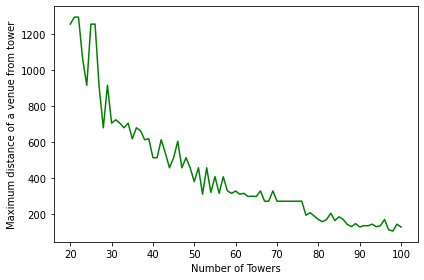

In [215]:
plt.plot(range(20,101),max_dist_list,'g')
plt.ylabel('Maximum distance of a venue from tower')
plt.xlabel('Number of Towers')
plt.tight_layout()
plt.show()

#### Elbow method is not relevant in this case as our focus is to have all venues within 400 m range of their towers. So, optimum value of k will be 50 for us.

#### Let us again carry out the k-means taking number of towers as 50, then plot it and check that no venue is out of range from its tower. You may need to execute k-means multiple times to achieve this as it gives slighlty different cluster formation each time.

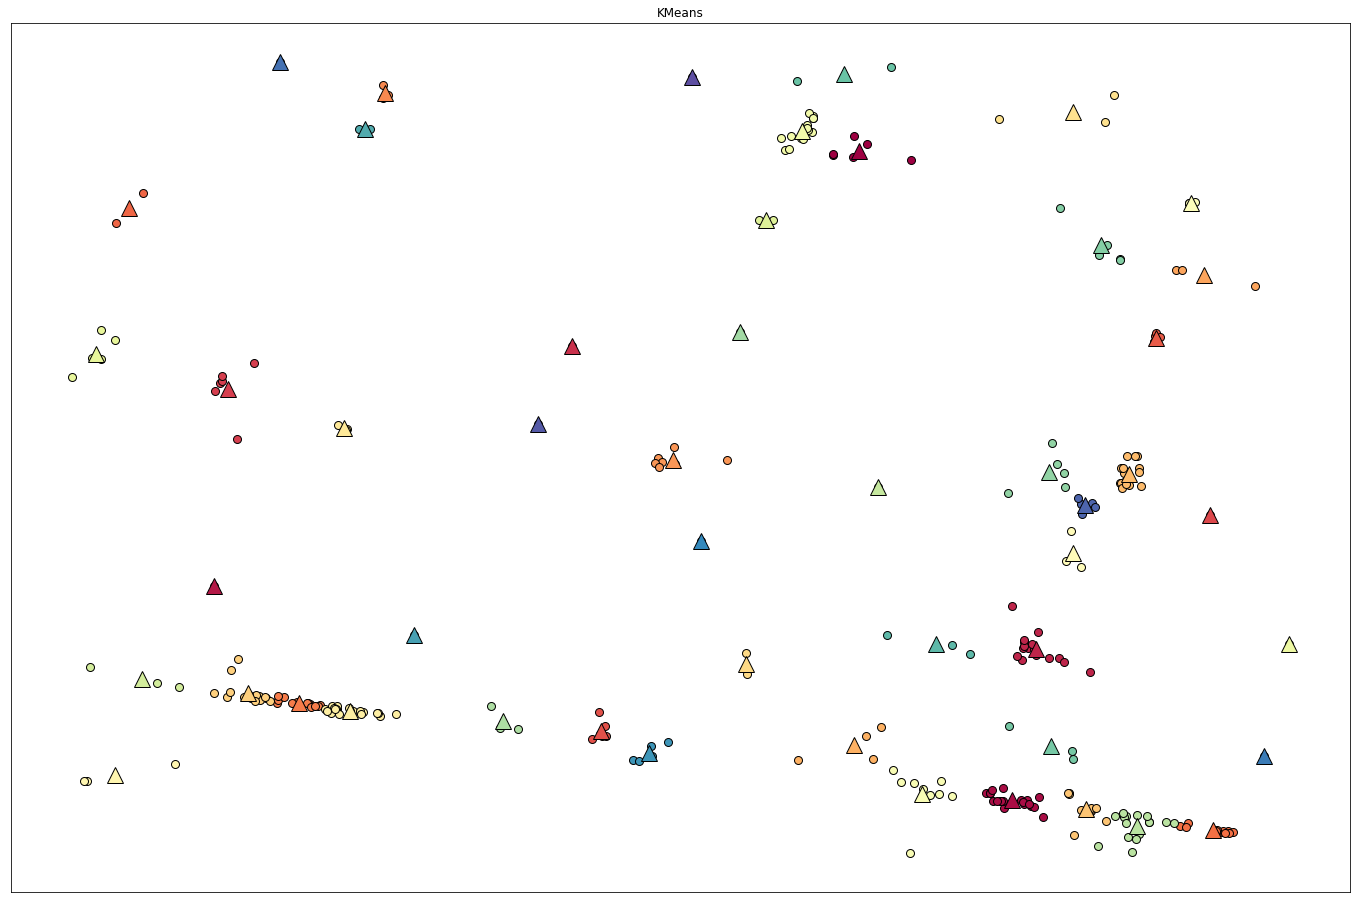

Maximum distance of a venue from tower is 382.045969284481


In [198]:
towers=50
k_means = KMeans(init = "k-means++", n_clusters = towers, n_init = 12)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(24, 16))
dis_all_list=[]
# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
col_list = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)




# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(towers), col_list):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k )
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    #Calculate distance from their own tower
    point1 = np.array(X[my_members]) 
    point2 = np.array((cluster_center[0],cluster_center[1]))
    dist=distance(point1,point2)
    dis_mask=dist>400
    dis_all_list.extend(dist)
    # Plots the datapoints with color col.
    ax.plot(point1[dis_mask , 0], point1[dis_mask, 1], 'x', markerfacecolor=col, marker='x', markersize=10,color=col) 
    ax.plot(point1[~dis_mask , 0], point1[~dis_mask, 1], 'x', markerfacecolor=col, marker='o', markeredgecolor='k',markersize=8,color=col) 
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], '^', markerfacecolor=col,  markeredgecolor='k', markersize=16)  

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()
# Print maximum distance of a venue
print('Maximum distance of a venue from tower is ' + str(max(dis_all_list)))

#### Now we have got the correct cluster formation with all venues in range of their towers and we can show it on a map

In [199]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, venue in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
for lat, lng, tower in zip(k_means_cluster_centers[:,0], k_means_cluster_centers[:,1], range(towers)):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)    
    
map_toronto

#### So, we were able to cover 281 venues with 50 towers. Let us add the tower number column to our venues dataframe

In [201]:
toronto_venues['Tower']=k_means_labels #Add a tower column to our dataframe

In [202]:
toronto_venues.head(10)

,City Points,City Points Latitude,City Points Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Tower
0,Toronto 11,43.72864909867068,-79.40463791281924,Bobbette & Belle,43.731339,-79.403769,Bakery,11
1,Toronto 11,43.72864909867068,-79.40463791281924,For The Win Cafe,43.728636,-79.403255,Bubble Tea Shop,18
2,Toronto 11,43.72864909867068,-79.40463791281924,T-buds,43.731247,-79.403640,Tea Room,11
3,Toronto 11,43.72864909867068,-79.40463791281924,Mastermind Toys,43.732046,-79.404141,Toy / Game Store,22
4,Toronto 11,43.72864909867068,-79.40463791281924,Menchies Frozen Yogurt,43.728336,-79.403173,Ice Cream Shop,18
5,Toronto 11,43.72864909867068,-79.40463791281924,The Belly Buster Submarines,43.733743,-79.404390,Sandwich Place,22
6,Toronto 11,43.72864909867068,-79.40463791281924,Shinobu by Maki Sushi,43.732562,-79.404147,Japanese Restaurant,22
7,Toronto 11,43.72864909867068,-79.40463791281924,The Burger Cellar,43.732362,-79.403894,Burger Joint,22
8,Toronto 11,43.72864909867068,-79.40463791281924,STACK,43.729311,-79.403241,BBQ Joint,18
9,Toronto 11,43.72864909867068,-79.40463791281924,The Rolling Pin,43.733315,-79.404318,Bakery,22


#### A tower which will serve more venues is expected to carry greater traffic. We will now categorise towers on the basis of the number of venues they will serve. This will help us in allotting resources accordingly. Also, if we face some issue in a tower regarding resource requirement and we solve it by increasing resources, then we can apply the same solution to other towers of the same category. This will help us in rectifying issues before they occur.

In [203]:
#Add a tower category column to our dataframe. Category means the number of venues that tower will serve
toronto_venues['Tower category'] = toronto_venues.groupby('Tower')['Tower'].transform('count')
toronto_venues.head(25)

,City Points,City Points Latitude,City Points Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Tower,Tower category
0,Toronto 11,43.72864909867068,-79.40463791281924,Bobbette & Belle,43.731339,-79.403769,Bakery,11,15
1,Toronto 11,43.72864909867068,-79.40463791281924,For The Win Cafe,43.728636,-79.403255,Bubble Tea Shop,18,17
2,Toronto 11,43.72864909867068,-79.40463791281924,T-buds,43.731247,-79.403640,Tea Room,11,15
3,Toronto 11,43.72864909867068,-79.40463791281924,Mastermind Toys,43.732046,-79.404141,Toy / Game Store,22,20
4,Toronto 11,43.72864909867068,-79.40463791281924,Menchies Frozen Yogurt,43.728336,-79.403173,Ice Cream Shop,18,17
5,Toronto 11,43.72864909867068,-79.40463791281924,The Belly Buster Submarines,43.733743,-79.404390,Sandwich Place,22,20
6,Toronto 11,43.72864909867068,-79.40463791281924,Shinobu by Maki Sushi,43.732562,-79.404147,Japanese Restaurant,22,20
7,Toronto 11,43.72864909867068,-79.40463791281924,The Burger Cellar,43.732362,-79.403894,Burger Joint,22,20
8,Toronto 11,43.72864909867068,-79.40463791281924,STACK,43.729311,-79.403241,BBQ Joint,18,17
9,Toronto 11,43.72864909867068,-79.40463791281924,The Rolling Pin,43.733315,-79.404318,Bakery,22,20


In [204]:
# Create a category list for towers
cat_list=toronto_venues.groupby(['Tower','Tower category']).size().reset_index().rename(columns={0:'count'})
cat_list

,Tower,Tower category,count
0,0,6,6
1,1,20,20
2,2,1,1
3,3,16,16
4,4,1,1
5,5,6,6
6,6,1,1
7,7,7,7
8,8,5,5
9,9,2,2


#### Now we can finally plot our venues and towers on map. Venues being served by same tower are coloured same. Also, towers of same category are coloured same. Towers can be identified by black edged circles.

In [205]:
# create map
map_clusters = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(towers)
#ys = [i + x + (i*x)**2 for i in range(towers)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
color_list = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))
rainbow = [colors.rgb2hex(i) for i in color_list]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue'], toronto_venues['Tower']):
    label = folium.Popup(str(poi) + ' Tower ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
for lat, lng, venue,category in zip(k_means_cluster_centers[:,0], k_means_cluster_centers[:,1], cat_list['Tower'],cat_list['Tower category']):
    label = 'Tower {}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[category-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)       
map_clusters

##### This finishes our project. We were able to cover all the venues with minimum towers using k-means.

##### In summary, I was able to find optimum location for towers in such a way that all venues were covered with minimum possible towers. I was also able to categorise towers on the basis of expected load. And finally I was able to visualise the results on a map.

#### 4. Discussion
##### Network planning is a very complex topic. Many different approaches could have been used. I used k-means algorithm and checked models for different values of K from 20 to 100 and selected minimum value of K which served our purpose of coverage. In this project our target was to provide coverage at only the venues. For WiFi hotspots this strategy can be used. But for actual mobile networks we mostly  need uniform coverage in entire city or area and need some other approach.

##### For categorising mobile towers, I used the parameter of number of venues being served. In future studies, I would like incorporate additional data about venues like footfall or expected visitors too. This will help in better categorisation of towers on the basis of expected load.


##### In the end I visualised venues and towers on a map. In future studies, work can be done on finding the way to connect these towers to backend network through shortest possible routes.


#### 5. Conclusions
##### Data science can be effectively used in telecommunication industry too. In this project we used k-means algorithm for network planning. And then we further classified towers too. So, data analysis can be useful in planning, maintenance , upgradation and expansion of telecommunication networks.